# Flight Price Prediction Case Study

Loading the required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Uploading the the data set
data_train=pd.read_csv('Final_flight.csv')
ds=pd.DataFrame(data=data_train)
ds

,Airlines,Date_of_Journey,Source,Destination,Dep_times,Arrival_time,Duration,Stops,Price
0,SpiceJet,10/11/2021,New Delhi,Mumbai,7:20,9:35,2h 15m,Non Stop,2998
1,SpiceJet,10/11/2021,New Delhi,Mumbai,6:20,8:40,2h 20m,Non Stop,2998
2,SpiceJet,10/11/2021,New Delhi,Mumbai,19:45,22:05,2h 20m,Non Stop,2998
3,SpiceJet,10/11/2021,New Delhi,Mumbai,18:55,21:05,2h 10m,Non Stop,3177
4,Air India,10/11/2021,New Delhi,Mumbai,7:00,9:05,2h 05m,Non Stop,4931
...,...,...,...,...,...,...,...,...,...
1225,IndiGo,27/11/2021,New Delhi,Hyderabad,11:20,17:35,6h 15m,1 Stop,16718
1226,Vistara,27/11/2021,New Delhi,Hyderabad,8:05,20:25,12h 20m,1 Stop,11310
1227,Air India,27/11/2021,New Delhi,Hyderabad,9:45,19:00,9h 15m,2 Stop(s),11678
1228,Air India,27/11/2021,New Delhi,Hyderabad,6:10,19:00,12h 50m,2 Stop(s),11678


# EDA

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airlines         1230 non-null   object
 1   Date_of_Journey  1230 non-null   object
 2   Source           1230 non-null   object
 3   Destination      1230 non-null   object
 4   Dep_times        1230 non-null   object
 5   Arrival_time     1230 non-null   object
 6   Duration         1230 non-null   object
 7   Stops            1230 non-null   object
 8   Price            1230 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 86.6+ KB


here are 1203 rows and 9 columns.All are object type varibale. Target varibale is continous and interger type.

In [4]:
# Checking missing values
ds.isnull().sum()

Airlines           0
Date_of_Journey    0
Source             0
Destination        0
Dep_times          0
Arrival_time       0
Duration           0
Stops              0
Price              0
dtype: int64

there is three  missing values in the data set

<AxesSubplot:>

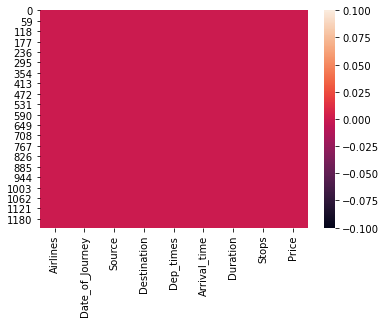

In [5]:
sns.heatmap(ds.isnull())

In [6]:
#As we can observe ‘Route’ and ‘Total_Stops’ both just 2 missing values. In this case, it is better to drop missing values.
ds.dropna(inplace= True)
ds.isnull().sum()

Airlines           0
Date_of_Journey    0
Source             0
Destination        0
Dep_times          0
Arrival_time       0
Duration           0
Stops              0
Price              0
dtype: int64

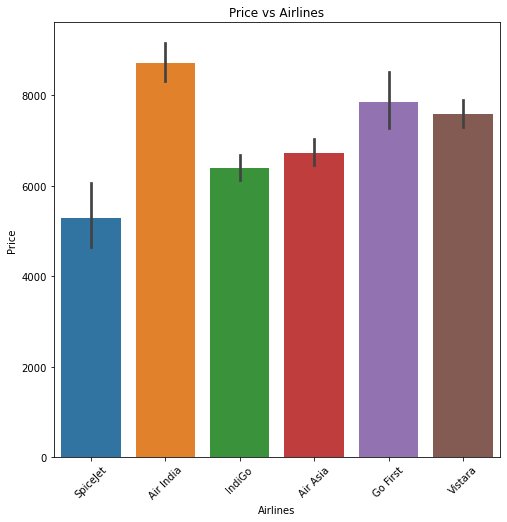

In [7]:
plt.figure(figsize=(8,8))
sns.barplot(x='Airlines',y='Price',data=ds)
plt.title("Price vs Airlines")
plt.xticks(rotation=45)
plt.show()

From graph we can see that Vistara Prmium Economy and Air India Business have the highest Price., Apart from the first Airline almost all are having similar median

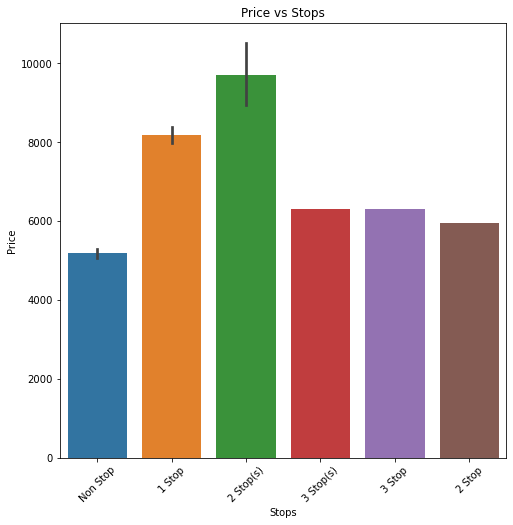

In [8]:
plt.figure(figsize=(8,8))
sns.barplot(x='Stops',y='Price',data=ds)
plt.title("Price vs Stops")
plt.xticks(rotation=45)
plt.show()

Key Observation: As the number of stops increases the price of fflight also increases.

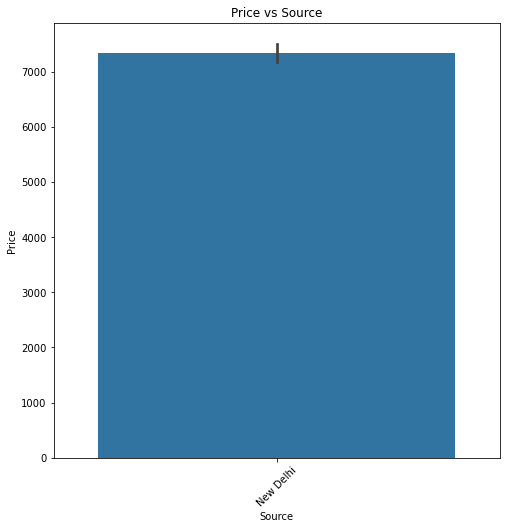

In [9]:
plt.figure(figsize=(8,8))
sns.barplot(x='Source',y='Price',data=ds)
plt.title("Price vs Source")
plt.xticks(rotation=45)
plt.show()

The flights with source Delhi has the the highest flight price then Kolkata and Banglore respectively

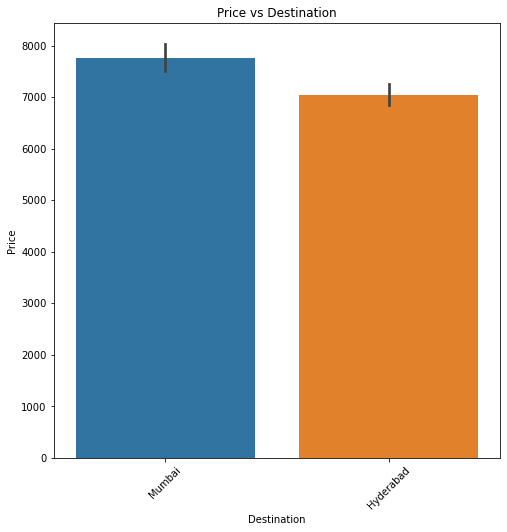

In [10]:
plt.figure(figsize=(8,8))
sns.barplot(x='Destination',y='Price',data=ds)
plt.title("Price vs Destination")
plt.xticks(rotation=45)
plt.show()

Key Observation: The flights with destination Mumbai has the the highest flight price then Hyderbad,New delhi respectively

<AxesSubplot:xlabel='Duration', ylabel='Price'>

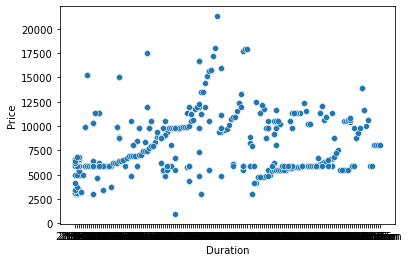

In [11]:
#duration v/s AveragePrice
sns.scatterplot(data=ds, x='Duration', y='Price')

We know that duration is important and plays a major role in affecting air ticket prices but we see no such pattern here, there must be other significant factors affecting air fare like type of airline, destination of flight, date of journey of flight.

# Data Wrangling

In [12]:
#firstly lets convert Date_of_journey,Arrival_Time and Dep_Time variables into date and time for proper predicion
def change_into_datetime(col):
    ds[col]=pd.to_datetime(ds[col])

In [13]:
for i in ['Date_of_Journey','Dep_times', 'Arrival_time']:
    change_into_datetime(i)

In [14]:
# Now we extract day and month from Date_of_journey and stored in 2 other columns
ds['journey-day']=ds['Date_of_Journey'].dt.day
ds['journey-month']=ds['Date_of_Journey'].dt.month

In [15]:
#now can drop 'Date_of_Journey' column
ds.drop('Date_of_Journey', axis=1, inplace=True)

In [16]:
# function for extracting hour and minutes From Arrival_time and Dept_time
def extract_hour(ds,col):
    ds[col+'_hour']=ds[col].dt.hour
    
def extract_min(ds,col):
    ds[col+'_min']=ds[col].dt.minute
    

def drop_col(ds,col):
    ds.drop(col,axis=1,inplace=True)


In [17]:
#call the function,Departure time is when a plane leaves the gate. 
# Similarly to Date_of_Journey,we can extract values from Dep_Time
extract_hour(ds,'Dep_times')

#extracting minutes
extract_min(ds,'Dep_times')

#drop the column
drop_col(ds,'Dep_times')

In [18]:
#extracting hour
extract_hour(ds,'Arrival_time')
#extracting min
extract_min(ds,'Arrival_time')
#drop the column
drop_col(ds,'Arrival_time')

In [19]:
ds.head(10)

,Airlines,Source,Destination,Duration,Stops,Price,journey-day,journey-month,Dep_times_hour,Dep_times_min,Arrival_time_hour,Arrival_time_min
0,SpiceJet,New Delhi,Mumbai,2h 15m,Non Stop,2998,11,10,7,20,9,35
1,SpiceJet,New Delhi,Mumbai,2h 20m,Non Stop,2998,11,10,6,20,8,40
2,SpiceJet,New Delhi,Mumbai,2h 20m,Non Stop,2998,11,10,19,45,22,5
3,SpiceJet,New Delhi,Mumbai,2h 10m,Non Stop,3177,11,10,18,55,21,5
4,Air India,New Delhi,Mumbai,2h 05m,Non Stop,4931,11,10,7,0,9,5
5,Air India,New Delhi,Mumbai,2h 10m,Non Stop,4931,11,10,8,0,10,10
6,IndiGo,New Delhi,Mumbai,2h 10m,Non Stop,4931,11,10,8,10,10,20
7,Air India,New Delhi,Mumbai,2h 10m,Non Stop,4931,11,10,17,50,20,0
8,Air India,New Delhi,Mumbai,2h 15m,Non Stop,4931,11,10,9,0,11,15
9,IndiGo,New Delhi,Mumbai,2h 15m,Non Stop,4931,11,10,20,0,22,15


In [20]:
# duration column,Separate hours and minute from duration
duration=list(ds['Duration'])
for i in range(len(duration)):
    if len(duration[i].split(' '))==2:
        pass
    else:
        if 'h' in duration[i]: # Check if duration contains only hour
             duration[i]=duration[i] + ' 0m' # Adds 0 minute
        else:
             duration[i]='0h '+ duration[i]

In [21]:
ds['Duration']=duration
ds.head()

,Airlines,Source,Destination,Duration,Stops,Price,journey-day,journey-month,Dep_times_hour,Dep_times_min,Arrival_time_hour,Arrival_time_min
0,SpiceJet,New Delhi,Mumbai,2h 15m,Non Stop,2998,11,10,7,20,9,35
1,SpiceJet,New Delhi,Mumbai,2h 20m,Non Stop,2998,11,10,6,20,8,40
2,SpiceJet,New Delhi,Mumbai,2h 20m,Non Stop,2998,11,10,19,45,22,5
3,SpiceJet,New Delhi,Mumbai,2h 10m,Non Stop,3177,11,10,18,55,21,5
4,Air India,New Delhi,Mumbai,2h 05m,Non Stop,4931,11,10,7,0,9,5


In [22]:
# duration column,Separate hours and minute from duration
def hour(x):
    return x.split(' ')[0][0:-1]

def minutes(x):
    return x.split(' ')[1][0:-1]

In [23]:
ds['duration_hr']=ds['Duration'].apply(hour)
ds['duration_min']=ds['Duration'].apply(minutes)
#drop the column
drop_col(ds,'Duration')

In [24]:
ds.head()

,Airlines,Source,Destination,Stops,Price,journey-day,journey-month,Dep_times_hour,Dep_times_min,Arrival_time_hour,Arrival_time_min,duration_hr,duration_min
0,SpiceJet,New Delhi,Mumbai,Non Stop,2998,11,10,7,20,9,35,2,15
1,SpiceJet,New Delhi,Mumbai,Non Stop,2998,11,10,6,20,8,40,2,20
2,SpiceJet,New Delhi,Mumbai,Non Stop,2998,11,10,19,45,22,5,2,20
3,SpiceJet,New Delhi,Mumbai,Non Stop,3177,11,10,18,55,21,5,2,10
4,Air India,New Delhi,Mumbai,Non Stop,4931,11,10,7,0,9,5,2,05


In [25]:
ds.dtypes

Airlines             object
Source               object
Destination          object
Stops                object
Price                 int64
journey-day           int64
journey-month         int64
Dep_times_hour        int64
Dep_times_min         int64
Arrival_time_hour     int64
Arrival_time_min      int64
duration_hr          object
duration_min         object
dtype: object

In [26]:
# Converting data type object into int
ds['duration_hr'] = ds['duration_hr'].astype(int)
ds['duration_min'] = ds['duration_min'].astype(int)

In [27]:
ds.dtypes

Airlines             object
Source               object
Destination          object
Stops                object
Price                 int64
journey-day           int64
journey-month         int64
Dep_times_hour        int64
Dep_times_min         int64
Arrival_time_hour     int64
Arrival_time_min      int64
duration_hr           int32
duration_min          int32
dtype: object

<AxesSubplot:>

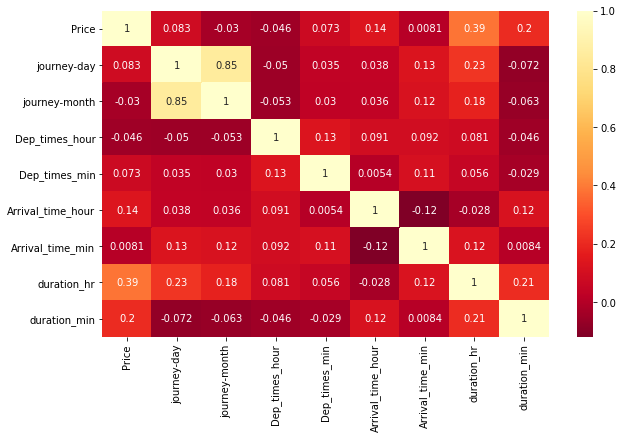

In [28]:
# Correlation Matrix ---Pearson Method
dfcor=ds.corr()
plt.figure(figsize=(10,6))
sns.heatmap(dfcor,cmap="YlOrRd_r",annot=True)

# Finding Outliers and Skewness

Price                   AxesSubplot(0.125,0.125;0.0435393x0.755)
journey-day          AxesSubplot(0.177247,0.125;0.0435393x0.755)
journey-month        AxesSubplot(0.229494,0.125;0.0435393x0.755)
Dep_times_hour       AxesSubplot(0.281742,0.125;0.0435393x0.755)
Dep_times_min        AxesSubplot(0.333989,0.125;0.0435393x0.755)
Arrival_time_hour    AxesSubplot(0.386236,0.125;0.0435393x0.755)
Arrival_time_min     AxesSubplot(0.438483,0.125;0.0435393x0.755)
duration_hr           AxesSubplot(0.49073,0.125;0.0435393x0.755)
duration_min         AxesSubplot(0.542978,0.125;0.0435393x0.755)
dtype: object

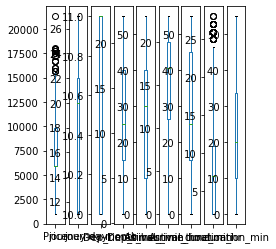

In [29]:
# Box plot for all coulmns
ds.plot(kind='box',subplots=True,layout=(1,15))

We can see there are outliers in price,duration_hr.Lets check separately.

<AxesSubplot:>

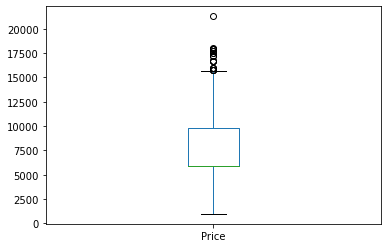

In [30]:
ds['Price'].plot.box()

<AxesSubplot:>

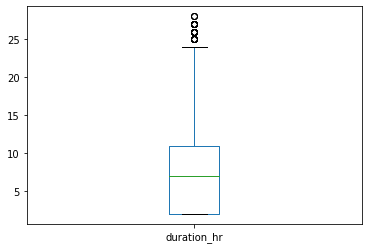

In [31]:
ds['duration_hr'].plot.box()

Outliers are presnent in price and duration_hr

In [32]:
# Cheking skew.
ds.skew()

Price                1.054220
journey-day         -0.151766
journey-month       -0.903788
Dep_times_hour       0.281689
Dep_times_min       -0.033715
Arrival_time_hour   -0.466555
Arrival_time_min     0.045185
duration_hr          1.195772
duration_min         0.656405
dtype: float64

In [33]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
oe =  OrdinalEncoder()
for i in ds.columns:
    if ds[i].dtypes=='object':
        ds[i]=oe.fit_transform(ds[i].values.reshape(-1,1))

In [34]:
ds

,Airlines,Source,Destination,Stops,Price,journey-day,journey-month,Dep_times_hour,Dep_times_min,Arrival_time_hour,Arrival_time_min,duration_hr,duration_min
0,4.0,0.0,1.0,5.0,2998,11,10,7,20,9,35,2,15
1,4.0,0.0,1.0,5.0,2998,11,10,6,20,8,40,2,20
2,4.0,0.0,1.0,5.0,2998,11,10,19,45,22,5,2,20
3,4.0,0.0,1.0,5.0,3177,11,10,18,55,21,5,2,10
4,1.0,0.0,1.0,5.0,4931,11,10,7,0,9,5,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,3.0,0.0,0.0,0.0,16718,27,11,11,20,17,35,6,15
1226,5.0,0.0,0.0,0.0,11310,27,11,8,5,20,25,12,20
1227,1.0,0.0,0.0,2.0,11678,27,11,9,45,19,0,9,15
1228,1.0,0.0,0.0,2.0,11678,27,11,6,10,19,0,12,50


In [35]:
# Removing outliers
m=ds[['Price','duration_hr']]

In [36]:
from scipy.stats import zscore
z=np.abs(zscore(m))
z
threshold=3
print(np.where(z>3))

(array([ 130,  131,  132,  132,  227,  259,  260,  261,  262,  383,  384,
        385,  386,  387,  534,  540,  570,  656,  930,  996,  999, 1002,
       1006, 1090, 1106, 1130, 1132, 1225], dtype=int64), array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0], dtype=int64))


In [37]:
# lets check the presence of outlier
print('shape before remooving the outliers:',ds.shape)
dsnew=ds[(z<3).all(axis=1)]

print('shape after remooving the outliers:',dsnew.shape)
# here 27 rows will be droped

shape before remooving the outliers: (1230, 13)
shape after remooving the outliers: (1203, 13)


In [38]:
#Checkking skewness
dsnew.skew()

Airlines            -0.071448
Source               0.000000
Destination          0.353271
Stops                0.750730
Price                0.782569
journey-day         -0.155639
journey-month       -0.904049
Dep_times_hour       0.275458
Dep_times_min       -0.040559
Arrival_time_hour   -0.465745
Arrival_time_min     0.060740
duration_hr          1.140951
duration_min         0.683571
dtype: float64

Keeping the skewness range +0.5/-0.5, however we are not going to remove outliers from objet type variabels and target variabel

# Creating feature and target dataframe

In [40]:
x=dsnew.drop(columns=['Price'])
y=dsnew['Price']

In [41]:
x.shape

(1203, 12)

In [42]:
y.shape

(1203,)

In [43]:
# lets bring all feature into common scale
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(x)

In [44]:
# To find the best random state using Linear Regressor model

from sklearn.metrics import r2_score
maxAccu=0
maxRS=0
for i in range(1,200):
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.30,random_state=i)
    mod=LinearRegression()
    mod.fit(x_train,y_train)
    pred=mod.predict(x_test)
    acc=r2_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print ('best r2 score is',maxAccu,'on random state',maxRS)

best r2 score is 0.5679461252691855 on random state 5


In [45]:
# Sending the data for train and test using Train_test_Split 
# 30 % data will go for testing and 70% data will go for training the model
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.30,random_state=maxRS)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(842, 12)
(361, 12)
(842,)
(361,)


70% of the data (842 rows) will be available for training the model & 30% (361 rows) will be available for testing the model

# Model Building & Evaluation

Since the target variable as continuous values we can build the regression models. Therefore oue evalution criteria will be: Evaluation Matrics : MAE,MSE,RMSE and R2 Score

In [46]:
lm=LinearRegression()
lm.fit(x_train,y_train)
lm.score(x_train,y_train)

0.4709930049702642

In [47]:
lm.coef_

array([-1.59742317e+02,  3.97903932e-13,  2.63313541e+03, -8.62909416e+02,
        2.96939711e+03, -8.31951130e+02, -2.18509206e+02,  2.19005692e+02,
        3.96480423e+02,  5.94982068e+01,  5.94305383e+02, -5.70667316e+01])

In [48]:
lm.intercept_

7176.285174798923

In [50]:
from sklearn.metrics import r2_score
pred=lm.predict(x_test)
print('Coefficient of determination',r2_score(y_test,pred))
print('mean absolute arror',mean_absolute_error(y_test,pred))
print('mean squarred arror',mean_squared_error(y_test,pred))
print('Root mean square arror',np.sqrt(mean_squared_error(y_test,pred)))

Coefficient of determination 0.5679461252691855
mean absolute arror 1333.5648622707508
mean squarred arror 2948948.5133290207
Root mean square arror 1717.250276846395


In [51]:
# Decision Tree Regression Model
dc=DecisionTreeRegressor()
dc.fit(x_train,y_train)
dc.score(x_train,y_train)

0.9743936232512141

In [52]:
from sklearn.metrics import r2_score
pred=dc.predict(x_test)
print('Coefficient of determination',r2_score(y_test,pred))
print('mean absolute error',mean_absolute_error(y_test,pred))
print('mean squarred error',mean_squared_error(y_test,pred))
print('Root mean square error',np.sqrt(mean_squared_error(y_test,pred)))

Coefficient of determination 0.7160431903269577
mean absolute error 469.3753462603878
mean squarred error 1938124.0644044322
Root mean square error 1392.1652432108885


In [53]:
# KNeighbors Regression Model
kn=KNeighborsRegressor()
kn.fit(x_train,y_train)
kn.score(x_train,y_train)

0.6974127999842219

In [54]:
from sklearn.metrics import r2_score
pred=kn.predict(x_test)
print('Coefficient of determination',r2_score(y_test,pred))
print('mean absolute error',mean_absolute_error(y_test,pred))
print('mean squarred error',mean_squared_error(y_test,pred))
print('Root mean square error',np.sqrt(mean_squared_error(y_test,pred)))

Coefficient of determination 0.5277430273792334
mean absolute error 1326.4581717451524
mean squarred error 3223351.4817728535
Root mean square error 1795.3694555084905


In [55]:
# Random Forest Regression Model
rf=RandomForestRegressor()
rf.fit(x_train,y_train)
rf.score(x_train,y_train)

0.958454230420262

In [56]:
from sklearn.metrics import r2_score
pred=rf.predict(x_test)
print('Coefficient of determination',r2_score(y_test,pred))
print('mean absolute error',mean_absolute_error(y_test,pred))
print('mean squarred error',mean_squared_error(y_test,pred))
print('Root mean square error',np.sqrt(mean_squared_error(y_test,pred)))

Coefficient of determination 0.8483442709909098
mean absolute error 522.8996741524866
mean squarred error 1035113.8197240402
Root mean square error 1017.4054352734903


Based on the results of above models, and capomaring the R2 score and other evalution matrics result of MAE,MSE and RMSE.We can find the Random Forest Regression model is best model to predict the . Since the Random Forest model has the second hishest score(0.98) and R2 score(0.92) and lowest values of MAE, MSE,RMSE among other four models build above, it is the best model among the above five models

# Improving the model accuracy using cross Validation¶

In [57]:
from sklearn.model_selection import cross_val_score
lmscores =cross_val_score(lm,x,y,cv=5)
print(lmscores)
print(lmscores.mean(),lmscores.std())

[0.34335308 0.23635697 0.53728487 0.20729467 0.26216924]
0.3172917664688602 0.11896592158596964


In [58]:
from sklearn.model_selection import cross_val_score
dcscores =cross_val_score(dc,x,y,cv=5)
print(dcscores)
print(dcscores.mean(),dcscores.std())

[ 0.86122973  0.81716691  0.53320681  0.24115754 -0.31824385]
0.4269034281096612 0.43404869243524363


In [59]:
from sklearn.model_selection import cross_val_score
knnscores =cross_val_score(kn,x,y,cv=5)
print(knnscores)

[ 0.6025721   0.49608297 -0.35472844  0.22577838 -0.71639717]


In [60]:
from sklearn.model_selection import cross_val_score
rfscores =cross_val_score(rf,x,y,cv=5)
print(rfscores)
print(rfscores.mean(),rfscores.std())

[0.88341462 0.63714703 0.65316033 0.24755088 0.07072275]
0.49839912159264993 0.2957265187281053


It can be observed that the "Random Forest Regressor" algorithim has the almost some positive accuracy score after the cross validation. So the best model with highet accuracy score and best on evalution with other matrix is "Random" is the best model for predicting the Price.

# HyperParameter Tuning

In [61]:
from sklearn.model_selection import GridSearchCV 
parameter={'criterion':['mse', 'mae'],'max_features':['auto', 'sqrt']}

In [62]:
GCV=GridSearchCV(RandomForestRegressor(),parameter,cv=5)

In [63]:
GCV.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_features': ['auto', 'sqrt']})

In [64]:
GCV.best_params_

{'criterion': 'mae', 'max_features': 'auto'}

In [66]:
rf_final=RandomForestRegressor(criterion= 'mae', max_depth= 30, max_features= 'auto')
rf_final.fit(x_train,y_train)
rf_final.score(x_train,y_train)

0.9532751764878631

In [67]:
from sklearn.metrics import r2_score
pred=rf_final.predict(x_test)
print('Coefficient of determination',r2_score(y_test,pred))
print('mean absolute error',mean_absolute_error(y_test,pred))
print('mean squarred error',mean_squared_error(y_test,pred))
print('Root mean square error',np.sqrt(mean_squared_error(y_test,pred)))

Coefficient of determination 0.8750229718232851
mean absolute error 516.6959972299169
mean squarred error 853020.521275554
Root mean square error 923.5911006909681


# Saving the best Model

In [68]:
import joblib
joblib.dump(rf_final,'Flight-Price_Preiction.obj')

['Flight-Price_Preiction.obj']